## **Import packages for analysis**

In [2]:
import anndata
import pandas as pd
import numpy as np
import loompy as lp

import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis,NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale

import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio

sc.set_figure_params(dpi=125)
sns.set_style('white')
     

## **Read in example dataset**

In [3]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'germCell_meta.csv')
meta.head()

,identity,cell_barcode
0,170830_AGPM_E10,170830_AGPM_E10:AGGTCATGTTGTCGCGx
1,170830_AGPM_E10,170830_AGPM_E10:ATCTGCCGTGCGAAACx
2,170830_AGPM_E10,170830_AGPM_E10:CAAGGCCCAAAGGAAGx
3,170830_AGPM_E10,170830_AGPM_E10:CAAGTTGTCCCATTTAx
4,170830_AGPM_E10,170830_AGPM_E10:CGTGTCTTCCAGAGGAx


In [4]:
ds = lp.connect('/home/tchari/counts/germcell_splicing/loom/allconds.loom')
ds

,,barcode,170830_AGPM_E10:AGGTCATGTTGTCGCGx,170830_AGPM_E10:ATCTGCCGTGCGAAACx,170830_AGPM_E10:CAAGGCCCAAAGGAAGx,170830_AGPM_E10:CAAGTTGTCCCATTTAx,170830_AGPM_E10:CGTGTCTTCCAGAGGAx,170830_AGPM_E10:CGTCTACAGCCACGCTx,170830_AGPM_E10:GCATGATAGTCCTCCTx,170830_AGPM_E10:GGACGTCGTAGCGATGx,170830_AGPM_E10:GGTGAAGGTTTGGCGCx,170830_AGPM_E10:GTACGTAGTCGCATATx,...
,,obs_names,170830_AGPM_E10:AGGTCATGTTGTCGCGx,170830_AGPM_E10:ATCTGCCGTGCGAAACx,170830_AGPM_E10:CAAGGCCCAAAGGAAGx,170830_AGPM_E10:CAAGTTGTCCCATTTAx,170830_AGPM_E10:CGTGTCTTCCAGAGGAx,170830_AGPM_E10:CGTCTACAGCCACGCTx,170830_AGPM_E10:GCATGATAGTCCTCCTx,170830_AGPM_E10:GGACGTCGTAGCGATGx,170830_AGPM_E10:GGTGAAGGTTTGGCGCx,170830_AGPM_E10:GTACGTAGTCGCATATx,...
gene_name,var_names,,,,,,,,,,,,...
Xkr4,Xkr4,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
Sox17,Sox17,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
Gm6085,Gm6085,,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...
Gm6119,Gm6119,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
Mrpl15,Mrpl15,,1.0,2.0,0.0,4.0,3.0,1.0,2.0,0.0,6.0,3.0,...
Gm6104,Gm6104,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
Rgs20,Rgs20,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...
Npbwr1,Npbwr1,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...


In [5]:
S = ds.layers['spliced'][:,:]
U = ds.layers['unspliced'][:,:]

In [6]:
g_names = ds.ra['gene_name']
bars = ds.ca['barcode']

In [7]:
ds.close()

In [8]:
adata_S = anndata.AnnData(S.T)
adata_S.obs_names = bars
adata_S.var_names = g_names

adata_U = anndata.AnnData(U.T)
adata_U.obs_names = bars
adata_U.var_names = g_names

adata_US = anndata.AnnData(U.T+S.T)
adata_US.obs_names = bars
adata_US.var_names = g_names

/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """Entry point for launching an IPython kernel.
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  """
/home/tchari/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get

In [9]:
np.unique(meta['identity'])

array(['170313_O_E16', '170313_T_E16', '170712_O_E16', '170712_T_E16',
       '170724_O_E12', '170724_T_E12', '170726_T_E13', '170802_T_E13',
       '170814_AGPF_E11', '170814_AGPM_E11', '170816_O_E12',
       '170816_T_E12', '170823_AGPF_E11', '170823_AGPM_E11',
       '170828_AGPF_E10', '170828_AGPM_E10', '170830_AGPF_E10',
       '170830_AGPM_E10', '180222_O_E13', '180410_O_E13'], dtype=object)

In [10]:
#Filter for cells in just one germ cell stage

#Ovary cells, E13: 180222_O_E13 or 180410_O_E13 <--
select = list(meta['cell_barcode'][meta['identity'].isin(['170726_T_E13'])])

adata_S2 = adata_S[select,:]
adata_U2 = adata_U[select,:]
adata_US2 = adata_US[select,:]

In [11]:
adata_U2

View of AnnData object with n_obs × n_vars = 2246 × 21103

## **Run standard clustering pipeline on modalities**

1. Run standard preprocessing, with count normalization and log1p of counts

2. Select 2000 HVGs for each modality

In [12]:
#Following https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html
def preproc_hvg(sub,hvgs=2000):
    sc.pp.normalize_total(sub, target_sum=1e4)
    sc.pp.log1p(sub)
    sc.pp.highly_variable_genes(sub, n_top_genes=hvgs,min_mean=0.0125, max_mean=3, min_disp=0.5)
    sc.pp.neighbors(sub, n_neighbors=10, n_pcs=40) #Should run pca for if hasn't been run yet
    
    return sub[:,sub.var.highly_variable]

In [13]:
adata_U_sub = preproc_hvg(adata_U2,hvgs=2000)
adata_S_sub = preproc_hvg(adata_S2,hvgs=2000)
adata_US_sub = preproc_hvg(adata_US2,hvgs=2000)

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


         Falling back to preprocessing with `sc.pp.pca` and default params.


Plot venn diagram of HVGs

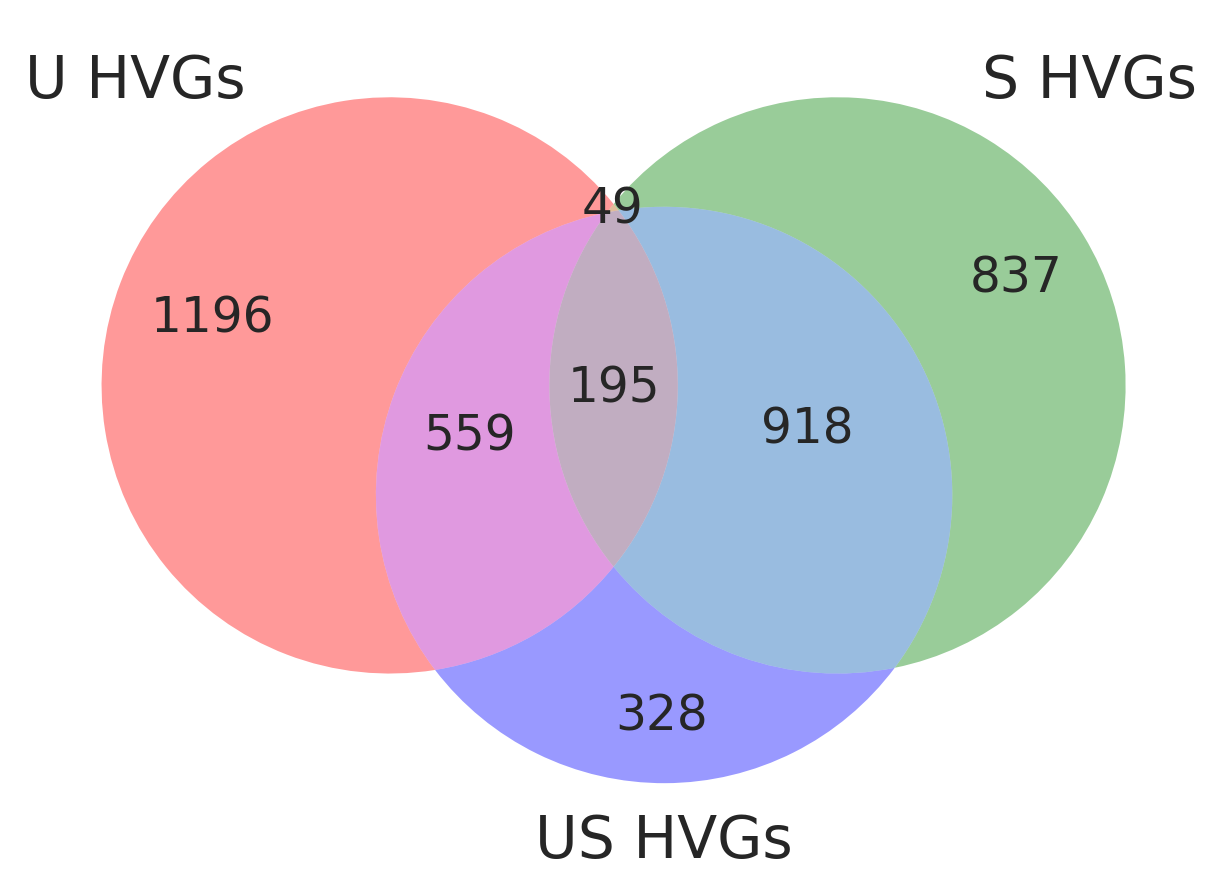

In [14]:
from matplotlib_venn import venn3
plt.figure(figsize=(6,6))
venn3([set(list(adata_U_sub.var_names)),set(list(adata_S_sub.var_names)) ,set(list(adata_US_sub.var_names))],
      ('U HVGs','S HVGs','US HVGs'))
plt.show()

In [15]:
adata_S_sub

View of AnnData object with n_obs × n_vars = 2246 × 1999
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors'
    obsm: 'X_pca'
    obsp: 'distances', 'connectivities'

3. Run Leiden clustering on inputs

In [16]:
sc.tl.leiden(adata_U_sub)
sc.tl.leiden(adata_S_sub)
sc.tl.leiden(adata_US_sub)

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/scanpy/tools/_leiden.py:157: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  categories=natsorted(map(str, np.unique(groups))),


4. Embed with UMAP to 2D and color by Leiden clusters

In [17]:
reducer = umap.UMAP(n_components = 2)
umap_U = reducer.fit_transform(adata_U_sub.obsm['X_pca'])
umap_S = reducer.fit_transform(adata_S_sub.obsm['X_pca'])
umap_US = reducer.fit_transform(adata_US_sub.obsm['X_pca'])
    

Make plots

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


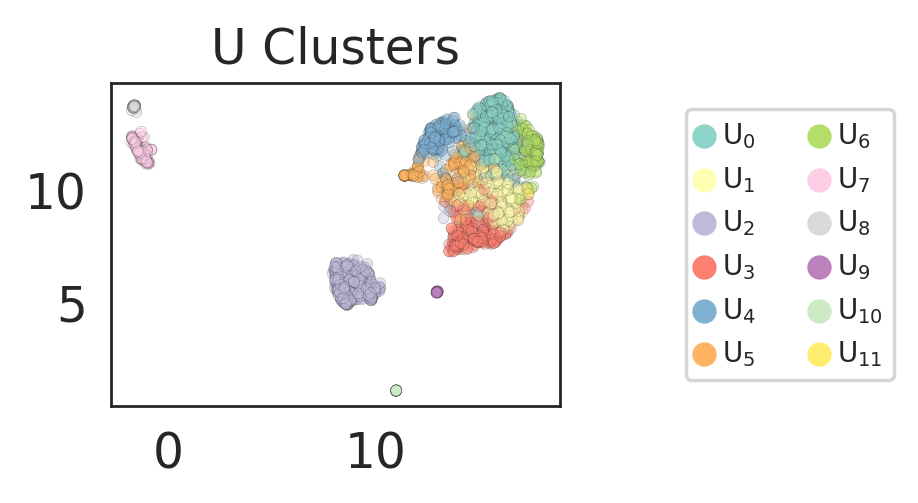

In [30]:
plt.figure(figsize=(4.3,2))
g=sns.scatterplot(umap_U[:,0],umap_U[:,1],hue=['$\mathrm{U}_'+'{'+i+'}$' for i in adata_U_sub.obs['leiden']],
                  palette='Set3',s=10,edgecolor='black',alpha=0.4,linewidth=0.1,
                 hue_order = ['$\mathrm{U}_{'+str(i)+'}$' for i in range(12)])
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2, fontsize=8)
plt.tight_layout()
plt.title('U Clusters')
plt.savefig('T_E13_U_umap_leiden.pdf')

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


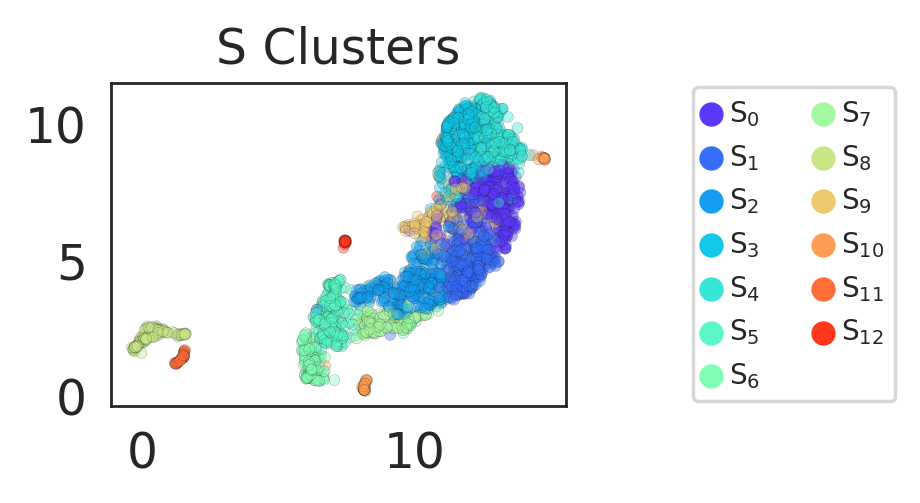

In [31]:
plt.figure(figsize=(4.3,2))
g=sns.scatterplot(umap_S[:,0],umap_S[:,1],hue=['$\mathrm{S}_'+'{'+i+'}$' for i in adata_S_sub.obs['leiden']],
                  palette='rainbow',s=10,edgecolor='black',alpha=0.4,linewidth=0.1,
                 hue_order = ['$\mathrm{S}_{'+str(i)+'}$' for i in range(13)])
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2, fontsize=8)
plt.tight_layout()
plt.title('S Clusters')
plt.savefig('T_E13_S_umap_leiden.pdf')

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


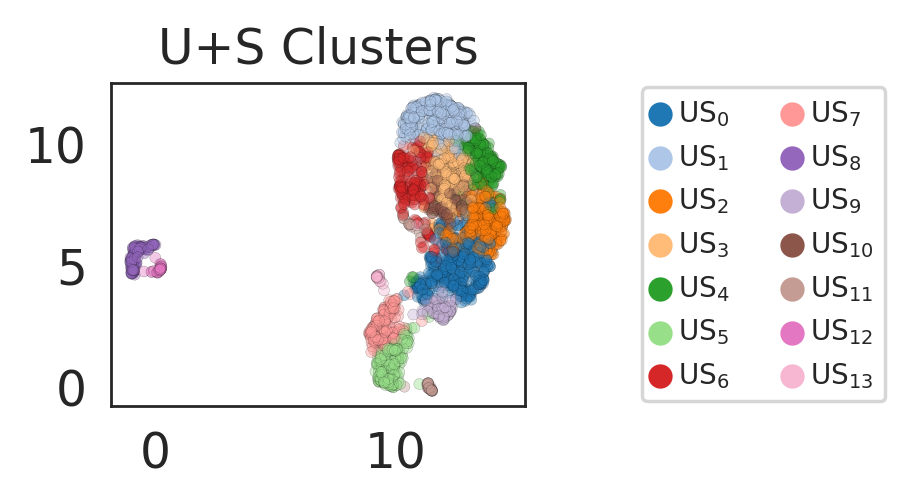

In [32]:
plt.figure(figsize=(4.3,2))
g=sns.scatterplot(umap_US[:,0],umap_US[:,1],hue=['$\mathrm{US}_'+'{'+i+'}$' for i in adata_US_sub.obs['leiden']],
                  palette='tab20',s=10,edgecolor='black',alpha=0.4,linewidth=0.1,
                 hue_order = ['$\mathrm{US}_{'+str(i)+'}$' for i in range(14)])
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2, fontsize=8)
plt.tight_layout()
plt.title('U+S Clusters')
plt.savefig('T_E13_US_umap_leiden.pdf')

In [25]:
from sklearn.metrics import confusion_matrix

Make 'Matching Matrices' between cluster labels to see overlap or discordance

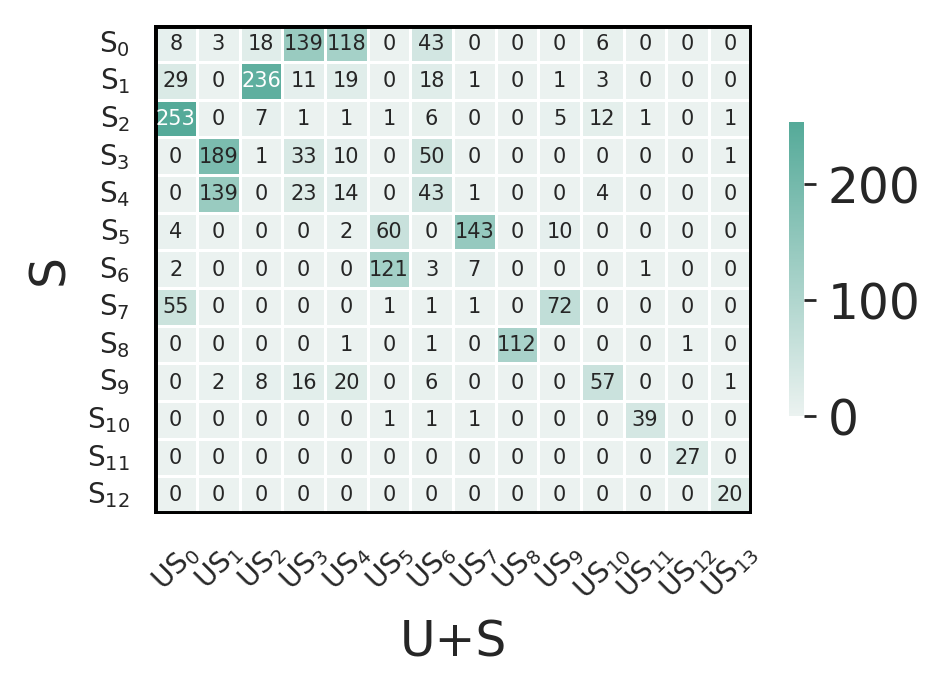

In [39]:
plt.figure(figsize=(4,3))
x = [int(i) for i in list(adata_S_sub.obs['leiden'])]
y = [int(i) for i in list(adata_US_sub.obs['leiden'])]


df = pd.DataFrame()
df['S'] = x
df['U+S'] = y

heatmap = sns.heatmap(pd.crosstab(index=df['S'], columns=df['U+S']), annot=True, fmt=".0f",
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),
                             square=False,linewidths=0.8, cbar_kws={"shrink": 0.6},
                     annot_kws={"fontsize":6},
                     xticklabels=True, yticklabels=True)

heatmap.yaxis.set_ticklabels(['$\mathrm{S}_{'+str(i)+'}$' for i in range(13)], rotation=0, ha='right',) 
heatmap.xaxis.set_ticklabels(['$\mathrm{US}_{'+str(i)+'}$' for i in range(14)],rotation=45 )


heatmap.axhline(y=0, color='k',linewidth=2)
heatmap.axhline(y=13, color='k',linewidth=2)
heatmap.axvline(x=0, color='k',linewidth=2)
heatmap.axvline(x=14, color='k',linewidth=2)


plt.tick_params(axis='both', which='minor', labelsize=8,)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.xlabel('U+S')
plt.ylabel('S')

plt.tight_layout()       
plt.savefig('T_E13_USvS_conf.pdf')

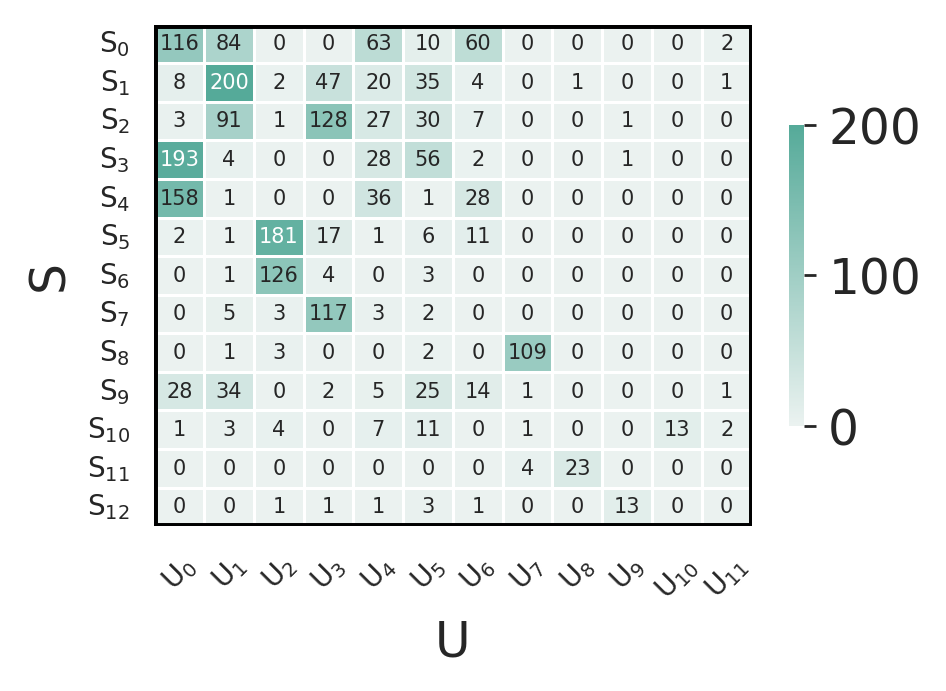

In [38]:
plt.figure(figsize=(4,3))
x = [int(i) for i in list(adata_S_sub.obs['leiden'])]
y = [int(i) for i in list(adata_U_sub.obs['leiden'])]

df = pd.DataFrame()
df['S'] = x
df['U'] = y

heatmap = sns.heatmap(pd.crosstab(index=df['S'], columns=df['U']), annot=True, fmt=".0f",
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),
                             square=False,linewidths=0.8, cbar_kws={"shrink": 0.6},
                     annot_kws={"fontsize":6},
                     xticklabels=True, yticklabels=True)
#sns.color_palette("light:#5A9", as_cmap=True)

heatmap.set_yticklabels(['$\mathrm{S}_{'+str(i)+'}$' for i in range(13)],)
heatmap.set_xticklabels(['$\mathrm{U}_{'+str(i)+'}$' for i in range(12)],rotation=45)

heatmap.axhline(y=0, color='k',linewidth=2)
heatmap.axhline(y=np.max(df['S'])+1, color='k',linewidth=2)
heatmap.axvline(x=0, color='k',linewidth=2)
heatmap.axvline(x=np.max(df['U'])+1, color='k',linewidth=2)


plt.tick_params(axis='both', which='minor', labelsize=8,)
plt.tick_params(axis='both', which='major', labelsize=8)

plt.xlabel('U')
plt.ylabel('S')

plt.tight_layout()       
plt.savefig('T_E13_UvS_conf.pdf')